In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_email = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Email_Classification/preprocess_train.csv')

mask = (df_email['Num_words_email'] > 25)

df_email = df_email[mask]

df_email = df_email[['all_text', 'classname']]

df_email = df_email.dropna()

df_email = df_email.groupby('classname').filter(lambda x: len(x) > 1)

df_email['classname_label'] = pd.Categorical(df_email['classname'])

df_email['classname'] = df_email['classname_label'].cat.codes

df_email.head()

,all_text,classname,classname_label
0,soc mot et al princeton ax matching fund boy s...,0,class_1
1,little satanicarticle mangoe charley wingate w...,0,class_1
2,theist postingarticle aic khan umar khan write...,0,class_1
3,genocide caused atheismnanci ann miller writes...,0,class_1
4,anecdote islamarticle jaeger gregg jaeger writ...,0,class_1


In [ ]:
df_email_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Email_Classification/preprocess_test.csv')

# mask = (df_email_test['Num_words_email'] > 25)

# df_email_test = df_email_test[mask]

df_email_test = df_email_test[['all_text', 'classname']]

df_email_test = df_email_test.dropna()

df_email_test['classname_label'] = pd.Categorical(df_email_test['classname'])

df_email_test['classname'] = df_email_test['classname_label'].cat.codes

print(len(df_email_test))
df_email_test.head()

1932


,all_text,classname,classname_label
0,islamic authority womanarticle bil bill conner...,0,class_1
1,death penalty wa re political atheistarticle b...,0,class_1
2,yet rushdie re islamic lawafp livesey jon live...,0,class_1
3,christian moralityarticle dp writes in article...,0,class_1
4,consciousness part ii kev strike backscott sau...,0,class_1


In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 64
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, oov_token="unk")
tokenizer.fit_on_texts(df_email['all_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50577 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df_email['all_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df_email['classname']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (2597, 500)
Shape of label tensor: (2597, 20)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2077, 500) (2077, 20)
(520, 500) (520, 20)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           3200000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 3,226,132
Trainable params: 3,226,132
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Epoch 1/20
59/59 [==============================] - 14s 184ms/step - loss: 2.9910 - accuracy: 0.0621 - val_loss: 2.9769 - val_accuracy: 0.0962
Epoch 2/20
59/59 [==============================] - 10s 170ms/step - loss: 2.8371 - accuracy: 0.1584 - val_loss: 2.6996 - val_accuracy: 0.1346
Epoch 3/20
59/59 [==============================] - 10s 170ms/step - loss: 2.4409 - accuracy: 0.2499 - val_loss: 2.4798 - val_accuracy: 0.1875
Epoch 4/20
59/59 [==============================] - 10s 169ms/step - loss: 2.0939 - accuracy: 0.3863 - val_loss: 2.3302 - val_accuracy: 0.2500
Epoch 5/20
59/59 [==============================] - 10s 169ms/step - loss: 1.6963 - accuracy: 0.5575 - val_loss: 2.2876 - val_accuracy: 0.2740
Epoch 6/20
59/59 [==============================] - 10s 168ms/step - loss: 1.3154 - accuracy: 0.7196 - val_loss: 2.1185 - val_accuracy: 0.3413
Epoch 7/20
59/59 [==============================] - 10s 169ms/step - loss: 1.0172 - accuracy: 0.8352 - val_loss: 2.2489 - val_accuracy: 0.3365

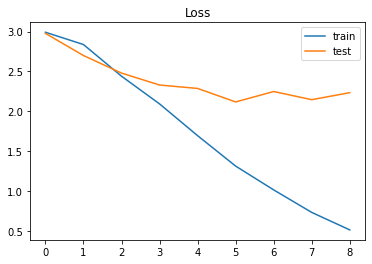

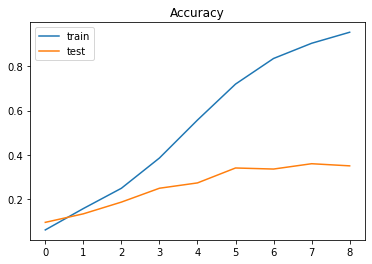

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [4]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

X = df_email.all_text
Y = df_email.classname

le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

print(X.shape)
print(np.unique(Y))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

print(X_test.shape)
print(np.unique(Y_test))

(2597,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(520,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, Y_train)

from sklearn.metrics import classification_report

print(X_test.head())
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred))

224     young catcherarticle kfy kirsch dave cursed ja...
2259    ftp unix do unixi new this found file public l...
1836    window workgroups lan workplaceflint water fli...
1858    window shareware monthly informationwindow sha...
957     space faq interest group publicationarchive na...
Name: all_text, dtype: object
accuracy 0.7557692307692307
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       1.00      0.57      0.72        30
           2       0.57      0.96      0.71        26
           3       0.90      0.95      0.93        40
           4       0.92      0.46      0.62        26
           5       0.56      0.96      0.70        26
           6       0.82      0.96      0.88        24
           7       0.66      0.95      0.78        22
           8       0.91      0.97      0.94        30
           9       1.00      0.86      0.93        22
          10       1.00      0.47      0.64        17
   

In [6]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=1000, tol=None)),
               ])
sgd.fit(X_train, Y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred))

accuracy 0.8365384615384616
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.96      0.90      0.93        30
           2       0.83      0.96      0.89        26
           3       0.93      0.95      0.94        40
           4       0.95      0.69      0.80        26
           5       0.83      0.92      0.87        26
           6       0.86      1.00      0.92        24
           7       0.71      0.91      0.80        22
           8       0.94      1.00      0.97        30
           9       0.95      0.86      0.90        22
          10       0.94      0.88      0.91        17
          11       0.79      0.74      0.77        31
          12       0.78      0.61      0.68        23
          13       0.72      0.85      0.78        34
          14       0.65      0.56      0.60        27
          15       0.75      0.79      0.77        19
          16       0.95      0.77      0.85        26

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=20)),
               ])
 
knn.fit(X_train, Y_train)

print(knn.score(X_test, Y_test))

0.75


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(max_depth=2, random_state=0, n_estimators=500)),
               ])
                
rf.fit(X_train, Y_train)
 
y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred))

accuracy 0.4173076923076923
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        20
           1       1.00      0.07      0.12        30
           2       0.41      0.96      0.57        26
           3       0.96      0.68      0.79        40
           4       0.00      0.00      0.00        26
           5       0.10      1.00      0.19        26
           6       0.85      0.71      0.77        24
           7       0.39      0.32      0.35        22
           8       1.00      0.43      0.60        30
           9       0.88      0.68      0.77        22
          10       0.00      0.00      0.00        17
          11       0.78      0.45      0.57        31
          12       0.00      0.00      0.00        23
          13       0.56      0.68      0.61        34
          14       1.00      0.04      0.07        27
          15       0.67      0.11      0.18        19
          16       1.00      0.08      0.14        26

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_email['classname'].value_counts()

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

before_vect = df_email[['all_text']]

columnTransformer = ColumnTransformer( [('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),'all_text')],
remainder='drop')

vector_transformer = columnTransformer.fit(before_vect)
vectorized_df = vector_transformer.transform(before_vect)
y = df_email['classname']
y=y.to_frame()

In [12]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
ros = RandomOverSampler(random_state=777)

X_ROS, y_ROS = ros.fit_sample(vectorized_df, y)

X_train, x_test, Y_train, y_test = train_test_split(X_ROS,y_ROS,test_size=0.2,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)

pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))

print(classification_report(y_test,pred_sgd))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.880718954248366
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       1.00      0.89      0.94        36
           2       0.87      0.94      0.90        35
           3       1.00      0.86      0.93        37
           4       0.83      0.83      0.83        30
           5       0.94      0.91      0.92        32
           6       0.96      0.96      0.96        28
           7       0.67      0.67      0.67        24
           8       1.00      0.97      0.99        34
           9       0.93      0.97      0.95        29
          10       0.92      0.97      0.94        35
          11       0.72      0.88      0.79        24
          12       0.72      0.79      0.75        33
          13       0.77      0.83      0.80        29
          14       0.79      0.77      0.78        30
          15       0.83      0.76      0.79        25
          16       0.96      0.87      0.91        30


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

smote = SMOTE(random_state=777,k_neighbors=20)
X_smote,y_smote = smote.fit_sample(vectorized_df,y)

X_train, x_test, Y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)

print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.8921568627450981
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.96      1.00      0.98        54
           2       1.00      0.92      0.96        51
           3       0.98      0.90      0.94        51
           4       0.89      0.85      0.87        46
           5       0.98      0.88      0.92        49
           6       0.93      0.95      0.94        44
           7       0.84      0.82      0.83        39
           8       0.92      0.98      0.95        47
           9       0.96      0.98      0.97        49
          10       0.89      0.98      0.93        48
          11       0.72      0.81      0.76        36
          12       0.82      0.85      0.84        48
          13       0.75      0.78      0.77        46
          14       0.80      0.80      0.80        46
          15       0.82      0.95      0.88        43
          16       0.95      0.89      0.92        45

In [ ]:
#predict real class

predict_vect = df_email_test[['all_text']]

vectorized_predict_df = vector_transformer.transform(predict_vect)
y_predict = df_email_test['classname']
y_predict=y_predict.to_frame()

# X_predict = df_email_test.all_text
# y_predict = df_email_test.all_text

realpredict = sgd.predict(vectorized_predict_df)

print('Accuracy %s' % accuracy_score(realpredict,y_predict))
print(classification_report(y_predict,realpredict))

Accuracy 0.7324016563146998
              precision    recall  f1-score   support

           0       0.56      0.57      0.56        88
           1       0.92      0.85      0.89       114
           2       0.89      0.95      0.92        97
           3       0.92      0.87      0.89       106
           4       0.72      0.58      0.64        96
           5       0.72      0.82      0.77        91
           6       0.82      0.90      0.86       105
           7       0.52      0.34      0.41        97
           8       0.66      0.89      0.76        87
           9       0.94      0.79      0.86       104
          10       0.69      0.56      0.62        78
          11       0.63      0.70      0.67        98
          12       0.39      0.53      0.45        70
          13       0.57      0.62      0.59        99
          14       0.62      0.61      0.61       107
          15       0.69      0.80      0.74        87
          16       0.84      0.64      0.73        98

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Y = pd.get_dummies(df_email['classname']).values
print('Shape of label tensor:', Y.shape)

smote = SMOTE(random_state=777,k_neighbors=20)
X_smote,y_smote = smote.fit_sample(vectorized_df,Y)

X_smote = X_smote.toarray()
type(y_smote)

Shape of label tensor: (2597, 20)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


numpy.ndarray

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
type(X_train)

NameError: ignored

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 64

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_smote.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50201, 64)         3200000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50201, 64)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1300      
Total params: 3,226,132
Trainable params: 3,226,132
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Epoch 1/20


In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
!pip install transformers

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
possible_labels = df_email.classname.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict

In [ ]:
df_email['label'] = df_email.classname.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(df_email.index.values, 
                                                  df_email.classname.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_email.classname.values)

print(df_email.shape[0])

df_email['data_type'] = ['not_set']*df_email.shape[0]

df_email.loc[X_train, 'data_type'] = 'train'
df_email.loc[X_val, 'data_type'] = 'val'

df_email.groupby(['classname', 'label', 'data_type']).count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df_email[df_email.data_type=='train'].all_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_email[df_email.data_type=='val'].all_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_email[df_email.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_email[df_email.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import torch

# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Email_Classification/data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9455376427478926
Validation loss: 0.826226860170181
F1 Score (Weighted): 0.7497587981654982


Epoch 2:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5739729980047307
Validation loss: 0.7487629190373879
F1 Score (Weighted): 0.7545445134237762


Epoch 3:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.38015777125711675
Validation loss: 0.7320238745556428
F1 Score (Weighted): 0.7836003814488283


Epoch 4:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2923376206485757
Validation loss: 0.7522689709654794
F1 Score (Weighted): 0.7806708771122084


Epoch 5:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.27093506899773667
Validation loss: 0.7522689709654794
F1 Score (Weighted): 0.7806708771122084


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Email_Classification/data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 0
Accuracy: 10/19

Class: 1
Accuracy: 19/19

Class: 2
Accuracy: 23/23

Class: 3
Accuracy: 20/21

Class: 4
Accuracy: 14/19

Class: 5
Accuracy: 22/23

Class: 6
Accuracy: 19/21

Class: 7
Accuracy: 15/18

Class: 8
Accuracy: 17/19

Class: 9
Accuracy: 17/18

Class: 10
Accuracy: 11/15

Class: 11
Accuracy: 12/22

Class: 12
Accuracy: 3/18

Class: 13
Accuracy: 17/23

Class: 14
Accuracy: 6/18

Class: 15
Accuracy: 13/16

Class: 16
Accuracy: 12/17

Class: 17
Accuracy: 9/18

Class: 18
Accuracy: 20/21

Class: 19
Accuracy: 17/22

